In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, average_precision_score
import matplotlib.pyplot as plt
import ast
from sklearn.model_selection import GridSearchCV
from sklearn import tree

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

from imblearn.over_sampling import ADASYN

In [3]:
# Load data
# This assumes data is in a DataFrame called df with 'NDVI', 'NBR' as columns and 'label' as target column
#df = pd.read_csv('data_file.csv')
data = pd.read_csv('../dataset_tables/final_dataset.csv')

In [4]:
data['Label'].value_counts()

Label
False    206
True      45
Name: count, dtype: int64

In [5]:

# def convert_string_to_list(item, desired_length=2):
#     if isinstance(item, (int, float)):
#         return [item] * desired_length
#     string = str(item)
#     string = string.replace('nan', '0')
#     try:
#         lst = ast.literal_eval(string)
#     except:
#         lst = [0] * desired_length
#     if len(lst) < desired_length:
#         lst.extend([0] * (desired_length - len(lst)))
#     elif len(lst) > desired_length:
#         lst = lst[:desired_length]
#     return lst

def convert_string_to_list(item):
    if isinstance(item, (int, float)):
        return [item]
    s = str(item)
    s = s.replace('nan', '0')
    lst = ast.literal_eval(s)
    return lst

# NBR ONLY
# Apply the conversion function to 'NBR' column only
# data['NBR'] = data['NBR'].apply(lambda x: convert_string_to_list(x))

# # Flatten each sublist for NBR
# X = np.array([np.ravel(nbr) for nbr in data['NBR']])

# # Labels
# y = data['Label'].values

# # Split data into training and test set
# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, test_size=0.3, random_state=42)
# NDVI AND NBR

# Apply the conversion function to 'NDVI' and 'NBR' columns
data['NDVI'] = data['NDVI'].apply(lambda x: convert_string_to_list(x))
data['NBR'] = data['NBR'].apply(lambda x: convert_string_to_list(x))
data['NDWI'] = data['NDWI'].apply(lambda x: convert_string_to_list(x))
data['NDBI'] = data['NDBI'].apply(lambda x: convert_string_to_list(x))

X = np.array([np.ravel(ndvi + nbr + ndwi + ndbi)
                for ndvi, nbr, ndwi, ndbi in zip(data['NDVI'], data['NBR'], data['NDWI'], data['NDBI'])])

# # Flatten each sublist and concatenate NBR and NDVI for each row
# X = np.array([np.ravel(ndvi + ndwi + ndbi)
#              for ndvi, ndwi, ndbi in zip(data['NDVI'], data['NDWI'], data['NDBI'])])

# X = np.array([np.ravel(ndvi + ndwi)
#              for ndvi, ndwi in zip(data['NDVI'], data['NDWI'])])

# Labels
y = data['Label'].values


In [6]:
# smote = SMOTE(random_state=42)
# X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [7]:
# rus = RandomUnderSampler(random_state=42)
# X_res, y_res = rus.fit_resample(X, y)

# X_train, X_test, y_train, y_test = train_test_split(
#     X_res, y_res, test_size=0.3, random_state=42)

In [8]:
adasyn = ADASYN(random_state=42)
X_res, y_res = adasyn.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(
    X_res, y_res, test_size=0.3, random_state=42)

In [9]:
X_train[1]

array([ 0.50856275,  0.34392176, -0.33907176, ..., -0.20885563,
       -0.23724907, -0.4636726 ])

In [10]:
# Initialize and train the Random Forest model

clf = RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42)
# clf.fit(X_train, y_train)
clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, n_estimators=200, random_state=42)

In [11]:
# Make predictions
y_pred = clf.predict(X_test)


In [12]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
map_score = average_precision_score(
    y_test, y_pred.reshape(-1, 1))

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Mean Average Precision: {map_score:.4f}")

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


Accuracy: 0.7969
Precision: 0.7179
Recall: 0.9333
Mean Average Precision: 0.7013
              precision    recall  f1-score   support

       False       0.92      0.68      0.78        68
        True       0.72      0.93      0.81        60

    accuracy                           0.80       128
   macro avg       0.82      0.80      0.80       128
weighted avg       0.83      0.80      0.79       128

[[46 22]
 [ 4 56]]


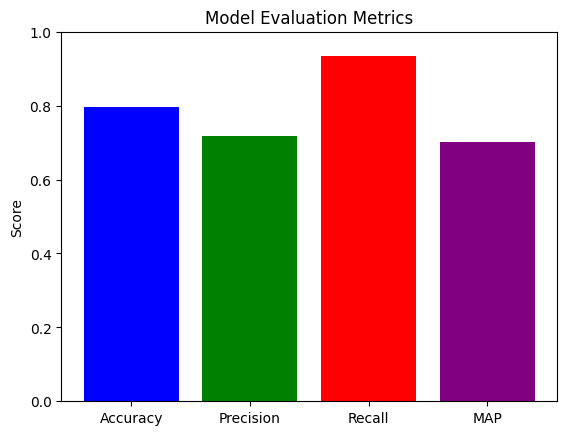

In [13]:
# Visualize the model evaluation metrics
metrics = ['Accuracy', 'Precision', 'Recall', 'MAP']
values = [accuracy, precision, recall, map_score]

plt.bar(metrics, values, color=['blue', 'green', 'red', 'purple'])
plt.ylabel('Score')
plt.title('Model Evaluation Metrics')
plt.ylim(0, 1)  # to set y-axis limits from 0 to 1
plt.show()


In [14]:
# Fine-tuning the model using Grid Search

param_grid = {
    'n_estimators': [50, 100, 200, 225, 250, 275, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(estimator=clf, param_grid=param_grid,
                           cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print("Best Parameters:", best_params)

best_clf = grid_search.best_estimator_


Fitting 3 folds for each of 252 candidates, totalling 756 fits
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.7s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.7s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.8s
[CV] END max_

In [15]:
# Feature importance

# importances = clf.feature_importances_
# for feature, importance in zip(['NDVI', 'NBR'], importances):
#     print(f"Feature: {feature}, Importance: {importance}")


Accuracy (Fine-tuned): 0.8203
Precision (Fine-tuned): 0.7403
Recall (Fine-tuned): 0.9500
F1 Score (Fine-tuned): 0.8321
Mean Average Precision (Fine-tuned): 0.7267
              precision    recall  f1-score   support

       False       0.94      0.71      0.81        68
        True       0.74      0.95      0.83        60

    accuracy                           0.82       128
   macro avg       0.84      0.83      0.82       128
weighted avg       0.85      0.82      0.82       128

[[48 20]
 [ 3 57]]


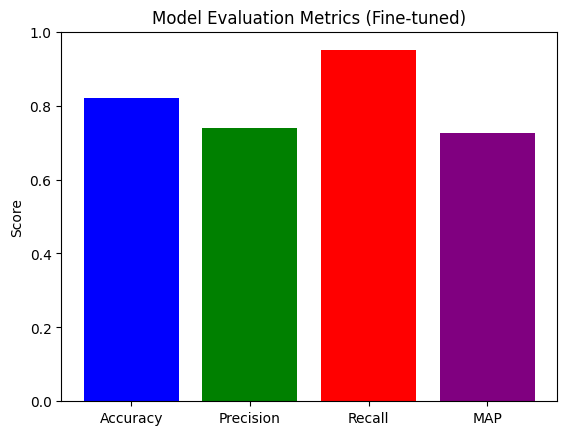

In [16]:
# Make predictions using the fine-tuned model
y_pred_best = best_clf.predict(X_test)

# Evaluate the fine-tuned model
accuracy_best = accuracy_score(y_test, y_pred_best)
precision_best = precision_score(y_test, y_pred_best)
recall_best = recall_score(y_test, y_pred_best)
f1_score_best = 2 * (precision_best * recall_best) / (precision_best + recall_best)
map_score_best = average_precision_score(
    y_test, y_pred_best.reshape(-1, 1))

print(f"Accuracy (Fine-tuned): {accuracy_best:.4f}")
print(f"Precision (Fine-tuned): {precision_best:.4f}")
print(f"Recall (Fine-tuned): {recall_best:.4f}")
print(f"F1 Score (Fine-tuned): {f1_score_best:.4f}")
print(f"Mean Average Precision (Fine-tuned): {map_score_best:.4f}")

print(classification_report(y_test, y_pred_best))
print(confusion_matrix(y_test, y_pred_best))

# Visualize the evaluation metrics for the fine-tuned model
metrics_best = ['Accuracy', 'Precision', 'Recall', 'MAP']
values_best = [accuracy_best, precision_best, recall_best, map_score_best]

plt.bar(metrics_best, values_best, color=['blue', 'green', 'red', 'purple'])
plt.ylabel('Score')
plt.title('Model Evaluation Metrics (Fine-tuned)')
plt.ylim(0, 1)
plt.show()


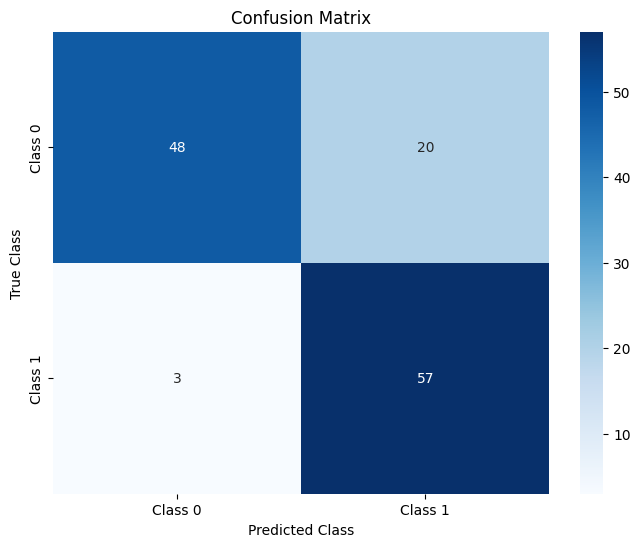

In [17]:
# Generate confusion matrix
import seaborn as sns

conf_matrix = confusion_matrix(y_test, y_pred_best)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.title('Confusion Matrix')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.show()

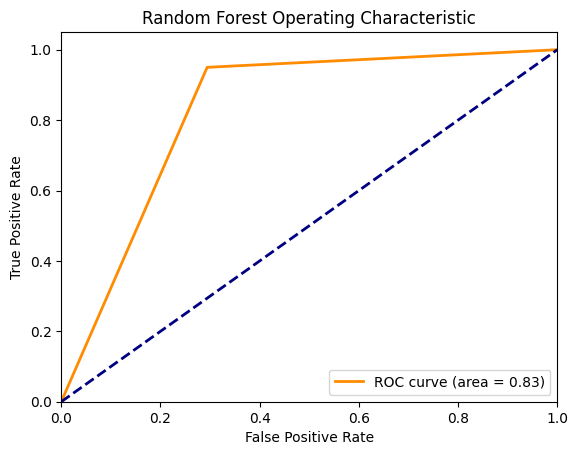

In [18]:
# ROC-AUC curve and score
from sklearn.metrics import roc_curve, roc_auc_score
fpr, tpr, _ = roc_curve(y_test, y_pred_best)
roc_auc = roc_auc_score(y_test, y_pred_best)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

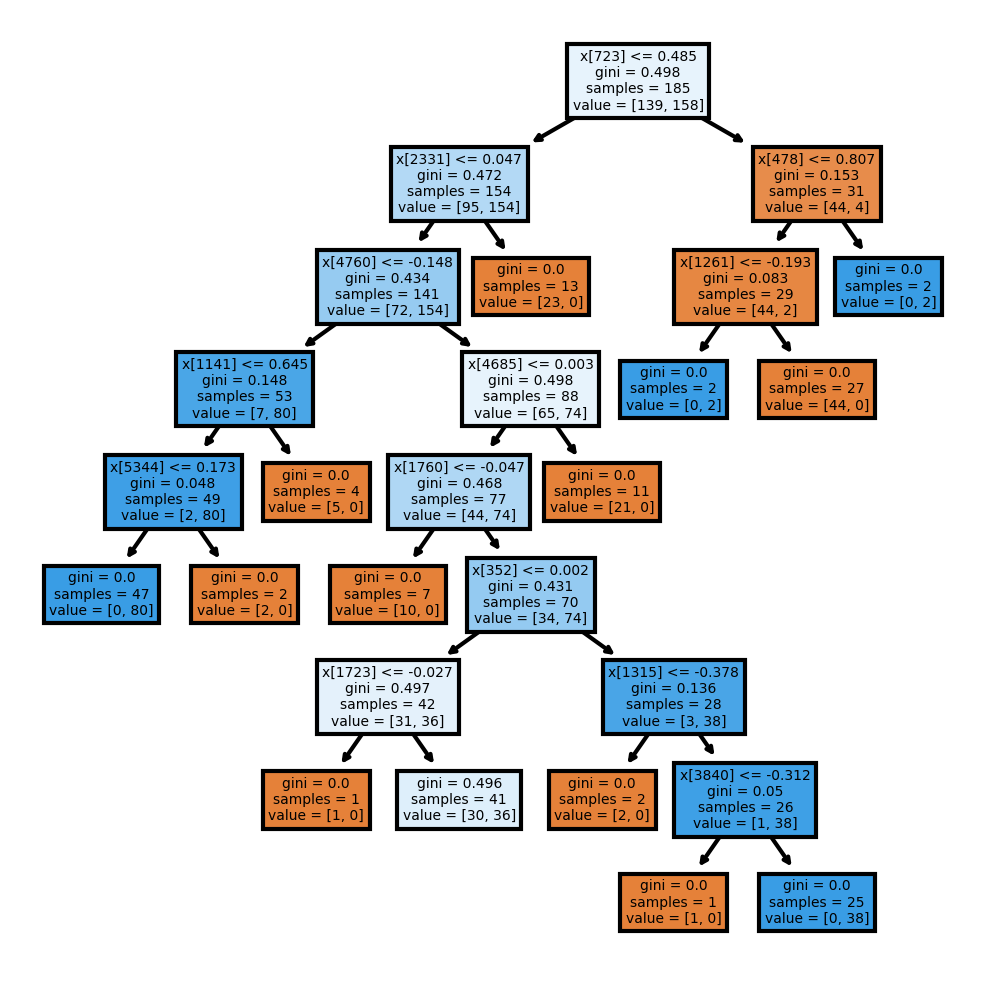

In [26]:
chosen_tree = best_clf.estimators_[0]

fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (4, 4), dpi=300)
tree.plot_tree(chosen_tree,
            #    feature_names=['Feature'],
            #    class_names='Label',
               filled=True)
plt.show()

In [24]:
# 测试样例
test_sample = X[0].reshape(1, -1)  # 取数据集的第一个样例

# 获取决策路径
decision_path = chosen_tree.decision_path(test_sample)

# 打印决策路径
print("Decision path in the tree:\n")
for node_index in decision_path.indices:
    # 提取并打印节点的详细信息
    if chosen_tree.tree_.children_left[node_index] == -1 and chosen_tree.tree_.children_right[node_index] == -1:
        print(f"Leaf node reached with class: {chosen_tree.tree_.value[node_index]}")
    else:
        print(f"Decision node {node_index} with threshold: {chosen_tree.tree_.threshold[node_index]}")


Decision path in the tree:

Decision node 0 with threshold: 0.4848448187112808
Decision node 1 with threshold: 0.0466894768178463
Leaf node reached with class: [[1. 0.]]
